In [1]:
import jax.numpy as np
# from jax.config import config; config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xara
import xaosim as xs
from xaosim.pupil import PHARO

from scipy.ndimage import fourier_shift

import morphine

import astropy.io.fits as fits 

from tqdm import tqdm

import pickle, gzip, glob

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

fftshift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

import os

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
# ddir = os.path.abspath(os.path.dirname("__file__"))
ddir = '/Users/benjaminpope/code/xara/xara/'
# -------------------------------
# 1. create the KP info structure
# -------------------------------

# once saved, the kpi.gz structure can be directly reloaded when 
# creating a KPO instance, such as done in step #2.

a = xara.KPI(ddir+"hst.txt")
a.name = "HST - NIC1" #  # add a label to the template
a.save_to_file('./hst.kpi.gz')


Attempting to load file /Users/benjaminpope/code/xara/xara/hst.txt
332 distinct baselines were identified
10 first singular values for this array:
[46.79691 46.33162 35.01308 34.70472 20.0892  19.939   16.52361 16.40732
 13.82746 13.76126]

        Summary of properties for hst.txt
        ---------------------------------------------------------------
        - 112 sub-apertures
        - 332 distinct baselines
        - 276 Ker-phases (83.1 % target phase information recovery)
        -  56 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully loaded


0

In [3]:
ls ../data/

hst/                   n8yj52020_mos.fits.gz  n8yj67020/
n8yj17010_mos.fits.gz  n8yj56010/             n9nk02010_mos.fits.gz
n8yj17020_mos.fits.gz  n8yj56020/             n9nk02020_mos.fits.gz
n8yj25010/             n8yj66010_mos.fits.gz  n9nk28010_mos.fits.gz
n8yj25020/             n8yj66020_mos.fits.gz  n9nk28020_mos.fits.gz
n8yj52010_mos.fits.gz  n8yj67010/


In [4]:
fits.getheader('HSTbinA.fits')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   20                                                  
NAXIS2  =                  302                                                  
NAXIS3  =                  256                                                  
EXTEND  =                    T                                                  

In [5]:
def shift(im,dx,dy):
    input_ = onp.fft.fft2(im)
    result = fourier_shift(input_, shift=(dx,dy))
    return onp.real(onp.fft.ifft2(result))

def sim_binary(im,sep,th,con,pscale):
    sep_pix = sep/pscale
    th_rad = np.pi*th/180.
    dx, dy = sep_pix*np.cos(-th_rad), sep_pix*np.sin(-th_rad)
    shifted = shift(im,dx,dy)
    return im+shifted/con 

def preprocess_like(data,kpo):
    isz = 128
    xsz,ysz = data.shape
    wrad = 50
    pscale = 43.1                              # plate scale (mas)
    cwavel = kpo.CWAVEL  # central wavelength
    isz    = 128                               # chop image
    m2pix  = xara.core.mas2rad(pscale)*isz/cwavel   # Fourier scaling
    tdiam  = 2.4                               # telescope diameter (m)
    spix   = xara.core.rad2mas(cwavel/tdiam)/pscale # image sampling (pixels)

    (x0, y0) = xara.core.determine_origin(data, mask=None,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    x1, y1 = int(x0-isz/2), int(y0-isz/2)
    img = data[y1:y1+isz, x1:x1+isz] # image is now (isz x isz)
    dy, dx   = (y0-ysz/2), (x0-xsz/2)

    sgmask = xara.core.super_gauss(isz, isz, isz/2, isz/2, wrad)
    (x0, y0) = xara.core.determine_origin(img, mask=sgmask,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    img = xara.core.recenter(data,verbose=False)
    nx,ny = img.shape
    limsx = int(nx/2-64), int(nx/2+64)
    limsy = int(ny/2-64), int(ny/2+64)
    img = img[limsx[0]:limsx[1],limsy[0]:limsy[1]] # from 512x512 -> 128x128
    return img

In [76]:
# -------------------
# 2. load the dataset
# -------------------

# load the FITS frame, and extract the Kernel-phases using the
# HST KPI template calculated at the previous step. 
# Two data sets are provided:
# n8yj59010_mos.fits.gz and 'n8yj59020_mos.fits.gz
fname = 'HSTbinA.fits'

tgt_cube = fits.getdata(fname) # alpha Ophiuchi

band = 'H'
if band == 'J':
    fname_b = "../data/n8yj67020/n8yj67020_mos.fits" # pope 2013 - calibrator - J band
    fname_b = '../data/n8yj66020_mos.fits.gz' # pope 2013 - calibrator - 2M 1221
    fname_kerphi = 'hstmorphine_32bit_64pix_J.kpi.gz'

elif band == 'H':
    fname_b = "../data/n8yj67010/n8yj67010_mos.fits" # pope 2013 - calibrator - H band - 2M1705
#     fname_b = "../data/n8yj56010/n8yj56010_mos.fits.gz" # pope 2013 - calibrator - 2M 1105
#     fname_source = '../data/n8yj66010_mos.fits.gz' # pope 2013 - calibrator - 2M 1221 - has a faint binary
    fname_source = '../data/n8yj52010_mos.fits.gz' # pope 2013 - calibrator - 2M 0911 - clipped
    fname_source = '../data/n9nk02010_mos.fits.gz' # pope 2013 - calibrator - 2M 0228 - ok
#     fname_source = '../data/n9nk28010_mos.fits.gz' # pope 2013 - calibrator - 2M 1421

#     fname_b = '../data/n8yj17010_mos.fits.gz' # pope 2013 - calibrator - 2M 1731 - has a faint binary
    fname_kerphi = 'hstmorphine_32bit_64pix.kpi.gz'
    fname_kerphi = 'hstmorphine_32bit_64pix_H.kpi.gz'
    fname_kerphi = 'hstmorphine_32bit_96pix_H.kpi.gz'
    fname_kerphi = 'hstmorphine_32bit_128pix_H.kpi.gz'
#     fname_kerphi = 'hstmorphine_64bit_128pix_H.kpi.gz'
#     fname_kerphi = 'hstmorphine_32bit_128pix_H.kpi.gz'
# fname = ddir+'/n8yj59010_mos.fits.gz' # frantz example

# fname_kerphi = './hst.kpi.gz'
# a = xara.KPO(fname_kerphi,offset=0.5)#xara.KPO(fname_kerphi,offset=0.5)
c = xara.KPO(fname_kerphi,offset=0.5)#xara.KPO(fname_kerphi,offset=0.5)

myf = gzip.open(fname_kerphi, "r")
stuff = pickle.load(myf)
myf.close()

c.M2PIX = xara.core.mas2rad(43.1) * 128 / 1.7057900000000002e-06
c.FF = stuff['dft']
b = c.copy()

dir_b = '../data/hst/cal/f170/*'

fnames_b = glob.glob(dir_b)
calibrators = []
otfs = []
for fb in fnames_b:
    if fname_source[8:16] in fb:
        continue
    try:
        b = c.copy()
    # b.extract_KPD(fname_b, wrad=50) # calibrator
        b.extract_KPD(fb,wrad=50)
        calibrators.append(b.KPDT[0][0])
        otf = np.abs(b.CVIS[0][0])
        otfs.append(otf/otf.max())
    except:
        print('failed on',fb)
calibrators = np.array(calibrators)
otfs = np.array(otfs)
pscale=b.PSCALE
wl = b.CWAVEL
print('Done calibrator')
cal = fits.getdata(fname_source).astype('float64')


Attempting to load file hstmorphine_32bit_128pix_H.kpi.gz
KPI data successfully loaded
File provided is not a fits file
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk31010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n9nk31010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj20010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n8yj20010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj35010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj51010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj28010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj32010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n

The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk11010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk04010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n9nk04010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj64010_mos.fits.gz, slice  1
failed on ../data/hst/cal/f170/n8yj64010_mos.fits.gz
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk03010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj12010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj63010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n8yj13010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk17

In [77]:
b = c.copy()


In [78]:
b.extract_KPD(fb,wrad=50)

The data comes from HST
1 data fits files will be opened
File ../data/hst/cal/f170/n9nk18010_mos.fits.gz, slice  1


In [79]:
# good_calibs = (onp.nanstd(calibrators,axis=1)<1)*(onp.nanstd(calibrators,axis=1)<0.02)*(onp.nanstd(otfs,axis=1)>0.1)
# calibrators = calibrators[good_calibs,:]
# otfs = otfs[good_calibs,:]
# print(calibrators.shape)

In [80]:
calibrators = calibrators[onp.nanstd(calibrators,axis=1)<1]
otfs = otfs[onp.nanstd(calibrators,axis=1)<1]

calibrators = calibrators[onp.nanstd(otfs,axis=1)>0.1]
otfs = otfs[onp.nanstd(otfs,axis=1)>0.1]


In [81]:
calibrators.shape

(43, 3794)

In [82]:
# calib  = np.median(np.array(calibrators),axis=0)
# calib = b.KPDT[0][0]
# coeffs = onp.linalg.lstsq(np.array(calibrators).T,a.KPDT[0][0], rcond=None)[0]
# calib = np.dot(coeffs,np.array(calibrators))

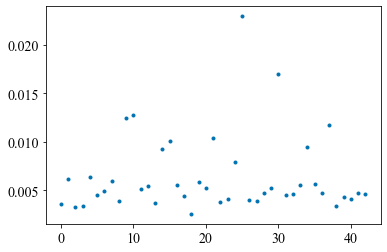

In [83]:
plt.plot(onp.nanstd(calibrators,axis=1),'.')

In [84]:
# dots = np.array([np.dot(cc,a.KPDT[0][0]) for cc in calibrators])

In [85]:
# plt.plot(dots,'.')

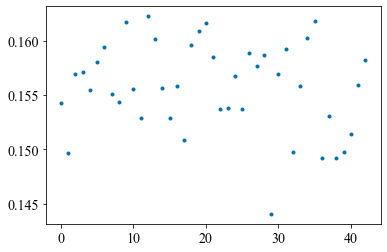

In [86]:
plt.plot(onp.nanstd(otfs,axis=1),'.')

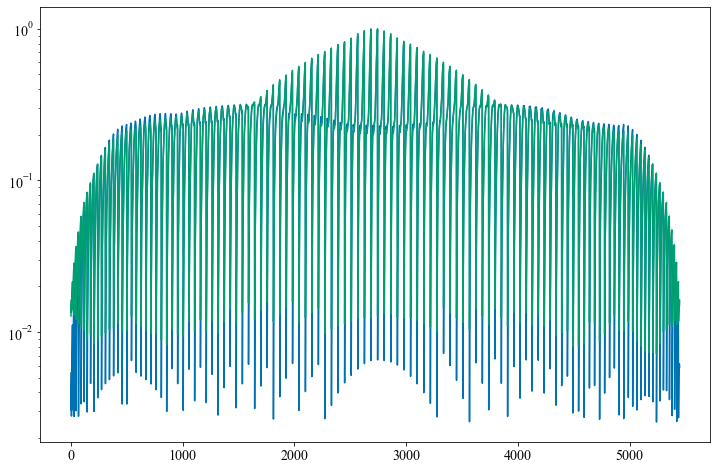

In [87]:
fig = plt.figure(figsize=(12.0,8.0))
plt.fill_between(np.arange(len(otfs[0,:])),np.median(otfs,axis=0)-np.std(otfs,axis=0),
                np.median(otfs,axis=0)+np.std(otfs,axis=0),alpha=0.2)
plt.plot(b.kpi.RED/b.kpi.RED.max())
plt.plot(np.mean(otfs,axis=0))

plt.yscale('log')

In [88]:
from sklearn.decomposition import PCA 

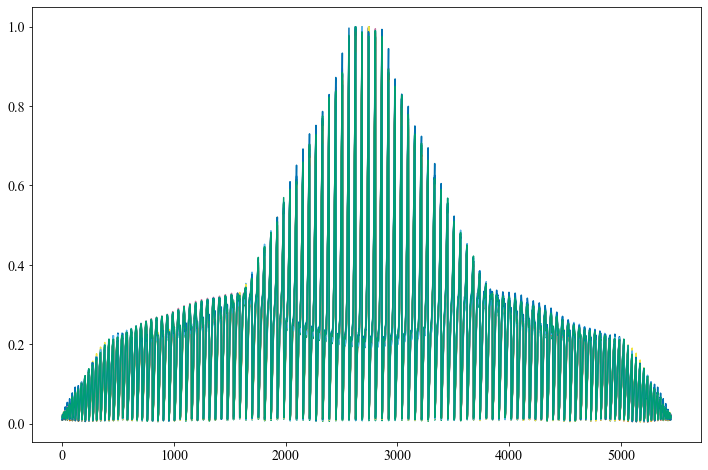

In [71]:
fig = plt.figure(figsize=(12.0,8.0))

for j in range(20):
    plt.plot(otfs[j,:],'-')

In [34]:
pca = PCA(n_components=5)
pca.fit(calibrators)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pca.components_.shape

(5, 3794)

In [36]:
pca.explained_variance_ratio_

array([0.17279607, 0.12633197, 0.094186  , 0.07551521, 0.06648728],
      dtype=float32)

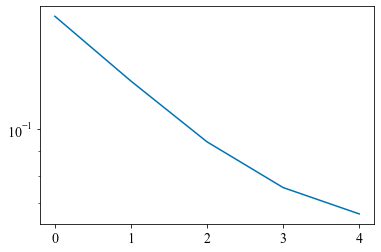

In [37]:
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

In [38]:
new_calibs = pca.fit_transform(calibrators)

In [39]:
reduced = pca.inverse_transform(new_calibs)


In [41]:
print(fits.getheader(fname_source)['FILTER'],fits.getheader(fname_b)['FILTER'],b.CWAVEL)


F170M F170M 1.7057900000000002e-06


In [42]:
# j = 15
# img = preprocess_like(tgt_cube[:,:,j],b)
truth = [150.,90,25]
binary = sim_binary(cal,*truth,43.1)
img_sim = preprocess_like(binary,b)
a = c.copy()
a.extract_KPD_single_frame(
img_sim, pscale, wl, recenter=True,method='LDFT1')
# calib  = pca.inverse_transform(pca.transform(a.KPDT[0]))[0]
calib = np.median(calibrators,axis=0)
mydata = a.KPDT[0][0]-calib
myerr = np.ones_like(mydata)*0.1*(onp.nanmedian(np.abs(mydata)))

a.kpi.name = "2M XXXX-XX" #  # labels the data
print('Done source')


Done source


In [43]:
mydata.shape

(3794,)

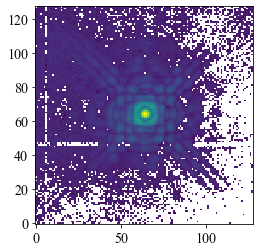

In [44]:
plt.imshow((img_sim)**0.25,interpolation='none')

In [45]:
# ls ../data/n8yj56010

In [46]:
# fits.getheader("../data/n8yj56010/n8yj56010_mos.fits.gz")

In [47]:
# a.plot_KPD()


computing colinearity map...
max colinearity found for sep = 170.29 mas and ang = 86.63 deg


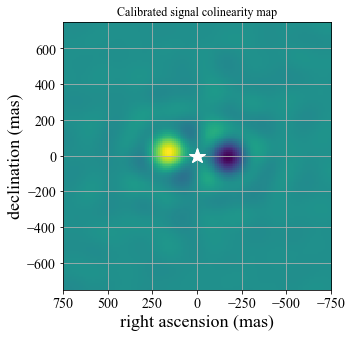

In [48]:
print("\ncomputing colinearity map...")
gsize = 150 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = a.kpd_binary_match_map(gsize, gstep, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()


In [49]:
from scipy.optimize import leastsq

def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary(u,v,wl, params, detpa))

def ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL"):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (myerr)
    return onp.array(error) 

def ben_binary_model_fit(p0,kpo=a,index=0,obs='KERNEL'):
    soluce = leastsq(ben_binary_model_fit_residuals, 
                 p0, args=((kpo,index, obs,)), full_output=1)

    return soluce



binary model fitting...
sep = 151.911070, ang=88.975227, con=27.209198 => chi2 = 2.719
correlation matrix of parameters
[[0.16 0.   0.02]
 [0.   0.   0.  ]
 [0.02 0.   0.  ]]


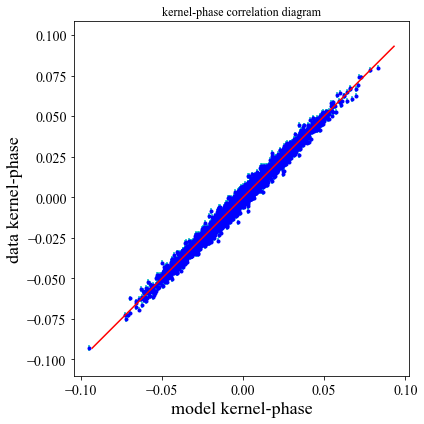

In [50]:
print("\nbinary model fitting...")
# p0 = params0 # good starting point
# p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
p0 = truth
p0[1] = np.mod(p0[1],360.)

wl = a.CWAVEL

# mfit = a.binary_model_fit(p0)
mfit = ben_binary_model_fit(p0,kpo=a)

p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
p1[1] = np.mod(p1[1],360.)
# p1 = p0
# p1 = p0


cvis_b = xara.core.cvis_binary(
        a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = (np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / a.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
print(np.round(mfit[1], 2))


### Now do a cube

In [51]:
results = []
myerr = np.ones_like(mydata)*0.01*(onp.nanmedian(np.abs(mydata)))
seps_in = np.linspace(90,500,20)
calib = np.median(calibrators,axis=0)


for j, sep_in in enumerate(seps_in):
#     img = preprocess_like(tgt_cube[:,:,j],b)
    
    truth = [sep_in,90,20]
    binary = sim_binary(cal,*truth,43.1)
    img_sim = preprocess_like(binary,b)
    a = c.copy()
    
    a.extract_KPD_single_frame(
    img_sim, pscale, wl, recenter=True,method='LDFT1')

    a.kpi.name = "simulation" #  # labels the data
#     calib  = pca.inverse_transform(pca.transform(a.KPDT[0]))[0]
    mydata = a.KPDT[0][0]-calib
    
#     print("\ncomputing colinearity map...")
#     gsize = 100 # gsize x gsize grid
#     gstep = 10 # grid step in mas
#     xx, yy = np.meshgrid(
#             np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
#     azim = -np.arctan2(xx, yy) * 180.0 / np.pi
#     dist = np.hypot(xx, yy) * gstep

#     #mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
#     mmap = a.kpd_binary_match_map(gsize, gstep, mydata, norm=True)
#     x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
#     print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
#             dist[y0, x0], azim[y0, x0]))
    
#     p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
    p0 = truth
    p0[1] = np.mod(p0[1],360.)

    # mfit = a.binary_model_fit(p0)
    mfit = ben_binary_model_fit(p0,kpo=a)

    p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
    p1[1] = np.mod(p1[1],360.)
    results.append(p1)

seps_out = np.array([result[0] for result in results])
thetas_out = np.array([result[1] for result in results])
cons_out = np.array([result[2] for result in results])

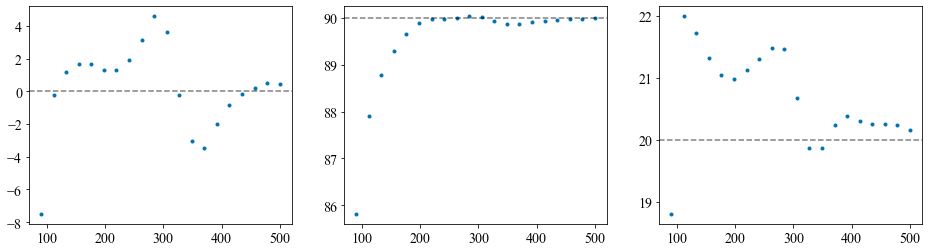

In [52]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16.0,4.0))
ax1.plot(seps_in,seps_out-seps_in,'.')
ax1.axhline(0,color='k',linestyle='--',alpha=0.5)
# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)

ax2.plot(seps_in,thetas_out,'.')
ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax3.plot(seps_in,cons_out,'.')
ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)

### Now try Peter's

In [ ]:
results = []
myerr = np.ones_like(mydata)*0.01*(onp.nanmedian(np.abs(mydata)))
calib = np.median(calibrators,axis=0)

do_cal = True

ssteps, thsteps = [], []
# plt.plot(0,0,'*')
for i in range(0,20):
    step=np.array((-0.17,0.28))*i + np.array((3.0,2.0))
#     print(step)
    sep_step = 43.1 * (np.hypot(*step))
    th_step = 180./np.pi*(np.angle(step[1]-1.j*step[0]))
#     plt.plot(step[0],step[1],'.')
    
    ssteps.append(sep_step)
    thsteps.append(th_step)
ssteps = np.array(ssteps)
thsteps = np.mod(np.array(thsteps),360)
# plt.axis('square')

for j in tqdm(range(20)):
    img = preprocess_like(tgt_cube[:,:,j],b)
    
    a = c.copy()

    a.extract_KPD_single_frame(
    img, pscale, wl, recenter=True,method='LDFT1')

    a.kpi.name = "simulation" #  # labels the data
    if do_cal:
        mydata = a.KPDT[0][0]-calib#b.KPDT[0][0]
    else:
        mydata = a.KPDT[0][0]

    
#     print("\ncomputing colinearity map...")
#     gsize = 100 # gsize x gsize grid
#     gstep = 5 # grid step in mas
#     xx, yy = np.meshgrid(
#             np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
#     azim = -np.arctan2(xx, yy) * 180.0 / np.pi
#     dist = np.hypot(xx, yy) * gstep

# #     mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
#     mmap = a.kpd_binary_match_map(gsize, gstep, mydata, norm=True)
#     x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
#     print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
#             dist[y0, x0], azim[y0, x0]))
    
#     p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
    p0 = [ssteps[j], thsteps[j],20]
    p0[1] = np.mod(p0[1],360.)
#     p0[0] = 150+j*10

    # mfit = a.binary_model_fit(p0)
    mfit = ben_binary_model_fit(p0,kpo=a)

    p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
    p1[1] = np.mod(p1[1],360.)
    p1[0] = np.abs(p1[0])
    results.append(p1)

if do_cal:
    seps_out_nocal = np.array([result[0] for result in results])
    thetas_out_nocal = np.array([result[1] for result in results])
    cons_out_nocal = np.array([result[2] for result in results])
else:
    seps_out = np.array([result[0] for result in results])
    thetas_out = np.array([result[1] for result in results])
    cons_out = np.array([result[2] for result in results])


 15%|█▌        | 3/20 [00:03<00:21,  1.29s/it]

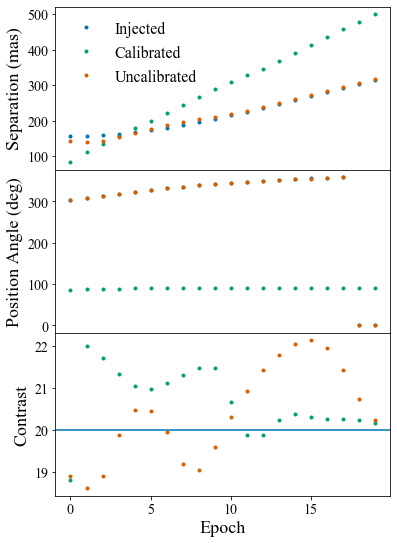

In [73]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,9),sharex=True)
ax1.plot(ssteps,'.',label='Injected')
ax1.plot(seps_out,'.',label='Calibrated')
ax1.plot(seps_out_nocal,'.',label='Uncalibrated')
ax1.set_ylabel('Separation (mas)')
# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)
ax1.legend(fontsize=16,frameon=False)
ax1.set_xticks([])

ax2.plot(thsteps,'.')
ax2.plot(thetas_out,'.')
ax2.plot(thetas_out_nocal,'.')
ax2.set_ylabel('Position Angle (deg)')
ax2.set_xticks([])

# ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax3.plot(cons_out,'.',color=colours[1])
ax3.plot(cons_out_nocal,'.',color=colours[2])
ax3.axhline(20)
ax3.set_ylabel('Contrast')
ax3.set_xlabel('Epoch')
ax2.set_xticks(np.arange(20)[::5])

plt.subplots_adjust(wspace=0, hspace=0)

# ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)
plt.savefig('hare_hounds.png',bbox_inches='tight')